End-to-end pipeline for object detection using a bounding box to recognise a target within an image and in real-time video.

Using classification for detecting faces, and regression for predicting the bounding box coordinates. Functional API will be used to use a base network VGG16 as the backbone, with 2 loss functions for each part of the face detection.

# 1. Setup and Data

## 1.1 Install dependencies and setup

In [1]:
# !pip install labelme tensorflow==2.8 tensorflow-gpu==2.8 opencv-python matplotlib albumentations

## 1.2 Collect images using OpenCV

In [3]:
import os
import time
import uuid # uniform unique identifier for file names
import cv2 # work with sensors & cameras for computer vision

In [4]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [13]:
# Using the webcam to take a video, take frames as images and add to the file path
# Run multiple times to add more images to the folder
cap = cv2.VideoCapture(0) # video capture device 1 (may have to change humber to get the right device)
for imgnum in range(number_images): # collecting images
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read() # captures the frame, giving a return value and the frame
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5) # sleep for 0.5 seconds between image captures to allow us to move in the frame
    
    #break out of the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

## 1.3 Annotate images with LabelMe

In [14]:
!labelme

Open directory location in labelme window
- Change output directory for drawn boundaries to the labels folder (file>change output directory)
- Change to save automatically

Edit > create rectangle (draw bounding box) > add class (do this for all images in the directory) > press 'd' for next image
- Any frames without a face can be saved wihtout a box

If a class was created by accident, go into the .JSON file and remove the class info from the file

# 2. Review Dataset and Build Image Loading Function

## 2.1 Import TF and Dependencies

In [15]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

## 2.2 Limit GPU Memory Growth

In [16]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [17]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [18]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2.3 Load Image into TF Data Pipeline

In [28]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=True) # * wild search for anything with .jpg extension

In [29]:
images.as_numpy_iterator().next()

b'data\\images\\42c2f3cc-167f-11ee-84f2-f4f26d0a6d5f.jpg'

In [30]:
# Load image function
def load_image(x): # pass file path
    byte_img = tf.io.read_file(x) # take file path and return byte encoded image 
    img = tf.io.decode_jpeg(byte_img) # decode image
    return img

In [31]:
images = images.map(load_image) # map applies the function load_iomage to every image in images (all images in filepath)

In [32]:
images.as_numpy_iterator().next()

array([[[174, 176, 173],
        [174, 176, 173],
        [174, 176, 173],
        ...,
        [125, 127, 122],
        [125, 127, 124],
        [125, 127, 124]],

       [[173, 175, 172],
        [173, 175, 172],
        [173, 175, 172],
        ...,
        [124, 126, 121],
        [125, 127, 124],
        [125, 127, 124]],

       [[173, 175, 172],
        [173, 175, 172],
        [173, 175, 172],
        ...,
        [124, 126, 123],
        [125, 127, 124],
        [125, 127, 124]],

       ...,

       [[167, 164, 147],
        [167, 164, 147],
        [167, 164, 147],
        ...,
        [156, 145, 149],
        [157, 146, 150],
        [159, 148, 152]],

       [[168, 165, 148],
        [168, 165, 148],
        [168, 165, 148],
        ...,
        [158, 146, 150],
        [159, 147, 151],
        [159, 147, 151]],

       [[169, 166, 149],
        [168, 165, 148],
        [168, 165, 148],
        ...,
        [158, 146, 150],
        [159, 147, 151],
        [159, 147, 151]]

In [33]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

## 2.4 Visualise images in matplotlib

In [34]:
image_generator = images.batch(4).as_numpy_iterator() # batch images into sets of 4

In [35]:
plot_images = image_generator.next()

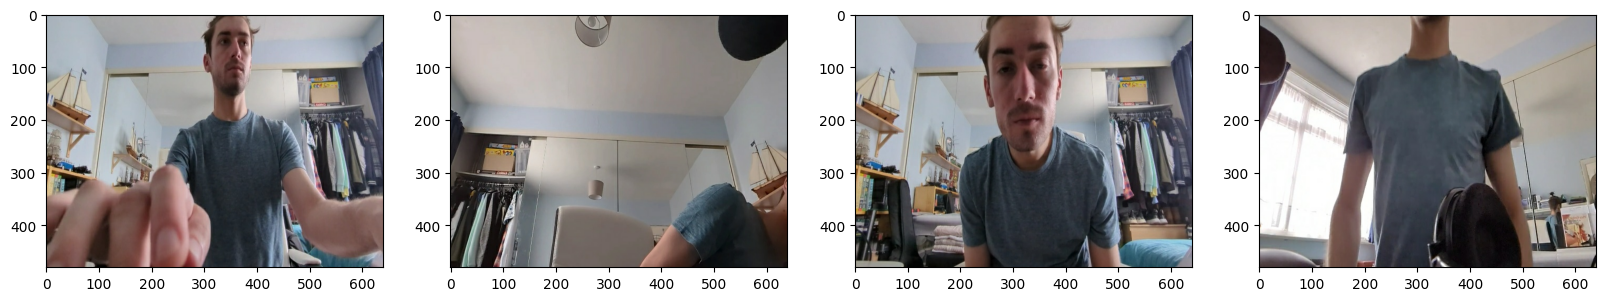

In [36]:
fig, ax = plt.subplots(ncols = 4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

# 3. Partition Unaugmented Data

## 3.1 MANUALLY SPLIT DATA INTO TRAIN, TEST AND VAL

Can use sklearn train_test_split for this, but doing manually here for full control

Creating folders manually and moving files

175 images

70% train - 0.7*175 = 

20% validate - 0.2*175 = 

10% test - 0.1*175 = 

In [37]:
0.7*175 # 122 to train

122.49999999999999

In [38]:
0.2*175 # 35 to validate

35.0

In [39]:
0.1 * 175 # 18 to test

17.5

In [40]:
122+35+18

175

## 3.2 Move the matching labels

In [41]:
# Loops over folders for labels that have the same name as the images and moves them to the corresponding labels folder
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

# 4. Apply image Augmentation on Images and Labels using Albumentations

## 4.1 Setup albumentations transform pipeline

In [42]:
import albumentations as alb

In [43]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## 4.2 Load a test image and annotation with OpenCV and JSON

In [49]:
img = cv2.imread(os.path.join('data','train', 'images','003f4a2a-167f-11ee-9d82-f4f26d0a6d5f.jpg')) # image from the training set

In [50]:
with open(os.path.join('data', 'train', 'labels', '003f4a2a-167f-11ee-9d82-f4f26d0a6d5f.json'), 'r') as f:
    label = json.load(f) # Load in matching annotation to the image

In [48]:
label['shapes'][0]['points'] # look at the bounding box (label is a dictionary and points gives the bounding box)

[[300.64516129032256, 72.90322580645162],
 [382.5806451612903, 193.54838709677418]]

## 4.3 Extract Coordinates and Rescale to match Image Resolution

In [54]:
# Converting into an array form a tensor
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [53]:
coords # [x1, y1, x2, y2]

[300.64516129032256, 72.90322580645162, 382.5806451612903, 193.54838709677418]

In [55]:
# normalising location to the image size (converting from pascal_voc to albumentations form)
coords = list(np.divide(coords, [640,480,640,480]))

In [56]:
coords

[0.469758064516129,
 0.15188172043010753,
 0.5977822580645161,
 0.4032258064516129]

## 4.4 Apply Image Augmentations and view results

In [57]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [59]:
augmented

{'image': array([[[150, 165, 168],
         [151, 166, 169],
         [151, 166, 169],
         ...,
         [139, 145, 156],
         [141, 149, 162],
         [143, 151, 164]],
 
        [[145, 164, 169],
         [145, 164, 169],
         [145, 164, 169],
         ...,
         [142, 148, 159],
         [143, 152, 162],
         [145, 153, 166]],
 
        [[132, 152, 163],
         [133, 153, 164],
         [133, 153, 164],
         ...,
         [145, 152, 161],
         [148, 155, 164],
         [147, 156, 166]],
 
        ...,
 
        [[186, 183, 178],
         [186, 183, 178],
         [186, 181, 178],
         ...,
         [192, 195, 203],
         [193, 196, 204],
         [193, 196, 204]],
 
        [[186, 183, 178],
         [186, 183, 178],
         [186, 181, 178],
         ...,
         [193, 197, 202],
         [192, 195, 203],
         [192, 195, 203]],
 
        [[185, 182, 177],
         [185, 182, 177],
         [186, 181, 178],
         ...,
         [191, 195,

In [58]:
augmented['bboxes'][0][2:]

(0.7746236559139784, 0.8868817204301075)

In [60]:
augmented['bboxes']

[(0.5925448028673834,
  0.6187813620071685,
  0.7746236559139784,
  0.8868817204301075)]

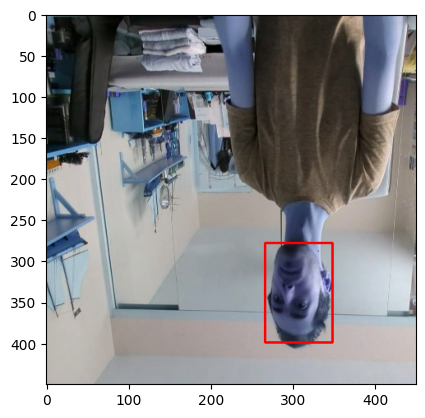

In [62]:
# Plots the bounding box form coordinates and the image
cv2.rectangle(augmented['image'], # plots the bounding box
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)), # top coordinates resized into 450x450
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), # bottom coordinates resized into 450x450
                    (255,0,0), 2) # make box red

plt.imshow(augmented['image']) # image has already been augmented, so call the image

# 5. Build and Run Augmenttaion Pipeline

## 5.1 Run Augmentation Pipeline

In [63]:
# Does the above for every image in the datasets

for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')): # taking every image from all folders
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path): # checks if image has an annotation (some images done have one) - if not, assigns a zero coordinate in coords
            with open(label_path, 'r') as f: # do transformation to convert to vector from a tensor
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60): # creating 60 images per base image (60 augmentations per image loaded, 60x the dataset)
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image']) # saving data in aug_data folder

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path): # get the coordinates
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 # No face is class 0


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f) # save coords

        except Exception as e:
            print(e)

image must be numpy array type


## 5.2 Load augmented images to Tensorflow Dataset

In [64]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [65]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [66]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [67]:
train_images.as_numpy_iterator().next()

array([[[0.01188726, 0.04669118, 0.01678922],
        [0.11868872, 0.13731618, 0.1098652 ],
        [0.28682598, 0.2956495 , 0.26966912],
        ...,
        [0.7223652 , 0.57726717, 0.50667894],
        [0.80441177, 0.675     , 0.61519605],
        [0.85729164, 0.7474877 , 0.7028799 ]],

       [[0.02267157, 0.05012255, 0.02218137],
        [0.08584559, 0.10398284, 0.08094363],
        [0.428125  , 0.43155637, 0.41341913],
        ...,
        [0.731924  , 0.5803922 , 0.51231617],
        [0.8014706 , 0.67107844, 0.6102941 ],
        [0.8557598 , 0.7430147 , 0.69987744]],

       [[0.02775735, 0.05226716, 0.02383578],
        [0.06219363, 0.08033089, 0.05827206],
        [0.42463234, 0.43247548, 0.42071077],
        ...,
        [0.73970586, 0.59117645, 0.51666665],
        [0.808701  , 0.67830884, 0.6175245 ],
        [0.86268383, 0.7499387 , 0.7068015 ]],

       ...,

       [[0.6691176 , 0.70441175, 0.7004902 ],
        [0.68284315, 0.70637256, 0.70637256],
        [0.67849267, 0

# 6. Prepare labels

## 6.1 Build label loading function

In [68]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox'] # extracting class and bounding box coordinates

## 6.2 Load labels to tensorflow dataset

In [69]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [70]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [71]:

val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [73]:

train_labels.as_numpy_iterator().next()

# class, coordinates

(array([1], dtype=uint8),
 array([0.6416, 0.57  , 0.8237, 0.838 ], dtype=float16))

# 7. Combine label and image samples

## 7.1 Check partition lengths

In [74]:

len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(7320, 7320, 1080, 1080, 2100, 2100)

## 7.2 Create final datasets (images/labels)

In [79]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(8000) # greater than the length of the dataset
train = train.batch(8)
train = train.prefetch(4)

In [80]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1500)
test = test.batch(8)
test = test.prefetch(4)

In [81]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2500)
val = val.batch(8)
val = val.prefetch(4)

In [82]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.4978  , 0.5547  , 0.7114  , 0.8384  ],
        [0.6133  , 0.2969  , 0.8726  , 0.698   ],
        [0.2458  , 0.001649, 0.4724  , 0.383   ],
        [0.383   , 0.5537  , 0.661   , 0.911   ],
        [0.3298  , 0.1487  , 0.5117  , 0.4197  ],
        [0.4648  , 0.03464 , 0.6353  , 0.4604  ],
        [0.2856  , 0.      , 0.6143  , 0.4312  ],
        [0.1841  , 0.0349  , 0.5195  , 0.4321  ]], dtype=float16))

In [83]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

## 7.3 View images and annotations

In [84]:
data_samples = train.as_numpy_iterator()

In [93]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


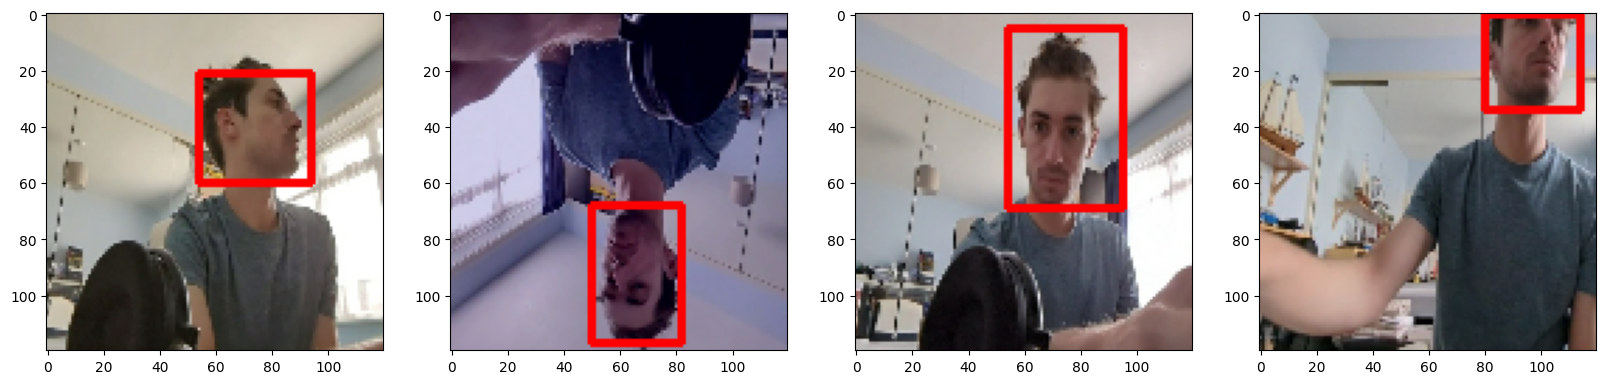

In [94]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build deep learning using functional API

## 8.1 Import layers and base network

In [95]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

## 8.2 Download VGG16

In [96]:
vgg = VGG16(include_top=False) # backbone pre-trained network build into tf (remove final layers)

58900480/58889256 [==============================] - 2s 0us/step


In [97]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## 8.3 Build instance of network

In [98]:
# Building 2 models (classification and regression models) from VGG16

def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1) # 1 output as is binary classification
    
    # Bounding box model (regression)
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) # 4 outputs for each coordinate
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## 8.4 Test out Neural Network

In [99]:
facetracker = build_model()

In [100]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [105]:
!pip install pydot graphviz


In [108]:
from tensorflow.keras.utils import plot_model
plot_model(facetracker, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [109]:
X, y = train.as_numpy_iterator().next()

In [110]:
X.shape

(8, 120, 120, 3)

In [111]:
# Predicted results without training a model
classes, coords = facetracker.predict(X)

In [112]:
classes, coords

(array([[0.51994187],
        [0.52535224],
        [0.55006576],
        [0.49856076],
        [0.46852127],
        [0.5515804 ],
        [0.50167483],
        [0.48068252]], dtype=float32),
 array([[0.5128266 , 0.63279486, 0.42498335, 0.3255723 ],
        [0.47978935, 0.5293347 , 0.44535184, 0.3055683 ],
        [0.512393  , 0.4900025 , 0.50608104, 0.29062673],
        [0.3857601 , 0.5461418 , 0.3715137 , 0.27393115],
        [0.42480442, 0.5608979 , 0.44753325, 0.26916096],
        [0.5014619 , 0.5695273 , 0.45344993, 0.34345624],
        [0.52018535, 0.5336248 , 0.48401973, 0.36029986],
        [0.41344365, 0.59966576, 0.5442714 , 0.2761656 ]], dtype=float32))

# 9. Define Losses and Optimizers

## 9.1 Define optimizer and LR

In [113]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [114]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## 9.2 Ceate Localization loss and classification loss

Object detection loss function YOLO

In [115]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) # distance between our predicted coordinate and actual coordinate (l2 Norm)
                  
    h_true = y_true[:,3] - y_true[:,1] # height of box
    w_true = y_true[:,2] - y_true[:,0] # width of box

    h_pred = yhat[:,3] - yhat[:,1] # predicted height of box
    w_pred = yhat[:,2] - yhat[:,0] # predicted width of box
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred)) # l2 norm for size of box
    
    return delta_coord + delta_size

In [116]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

## 9.3 Test out loss metrics

Uses predictions from no model

In [117]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.667446>

In [118]:
classloss(y[0], classes) # y[0] is predicted class

<tf.Tensor: shape=(), dtype=float32, numpy=0.68012697>

In [119]:
regressloss(y[1], coords) # y[1] is predicetd bounding coordinated

<tf.Tensor: shape=(), dtype=float32, numpy=5.667446>

In [120]:
y[0], y[1]

(array([[0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.3086 , 0.     , 0.5396 , 0.317  ],
        [0.1395 , 0.193  , 0.4207 , 0.597  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.641  , 0.2532 , 0.882  , 0.663  ],
        [0.365  , 0.     , 0.7275 , 0.5464 ],
        [0.04803, 0.2062 , 0.3806 , 0.5273 ],
        [0.6543 , 0.4949 , 0.8706 , 0.8477 ]], dtype=float16))

# 10. Train Neural Network

## 10.1 Create custom model class

In [121]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True) # takes images
            
            batch_classloss = self.closs(y[0], classes) # loss classification
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords) # loss regression
            
            total_loss = batch_localizationloss+0.5*batch_classloss # combine for 1 total loss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables) # calculate gradient (getting gradients with respect to the loss functions)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables)) # gradient descent with back propagation
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): # validation step (same as above with no back prop just calculates loss metrics)
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): # implement .predict
        return self.model(X, **kwargs)

In [122]:
model = FaceTracker(facetracker)

In [123]:
model.compile(opt, classloss, regressloss)

## 10.2 Train

In [124]:
logdir='logs'

In [125]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [126]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
915/915 [==============================] - 87s 77ms/step - total_loss: 0.2315 - class_loss: 0.0549 - regress_loss: 0.2041 - val_total_loss: 0.0313 - val_class_loss: 0.0013 - val_regress_loss: 0.0306
Epoch 2/10
915/915 [==============================] - 68s 67ms/step - total_loss: 0.0552 - class_loss: 0.0143 - regress_loss: 0.0480 - val_total_loss: 0.0158 - val_class_loss: 1.4009e-04 - val_regress_loss: 0.0157
Epoch 3/10
915/915 [==============================] - 69s 68ms/step - total_loss: 0.0311 - class_loss: 0.0091 - regress_loss: 0.0265 - val_total_loss: 0.0237 - val_class_loss: 0.0186 - val_regress_loss: 0.0143
Epoch 4/10
915/915 [==============================] - 69s 67ms/step - total_loss: 0.0356 - class_loss: 0.0091 - regress_loss: 0.0311 - val_total_loss: 0.0079 - val_class_loss: 7.5093e-04 - val_regress_loss: 0.0075
Epoch 5/10
915/915 [==============================] - 67s 65ms/step - total_loss: 0.0134 - class_loss: 0.0028 - regress_loss: 0.0120 - val_total_loss: 0

## 10.3 Plot performance

In [127]:
hist.history

{'total_loss': [0.48323842883110046,
  0.05952446907758713,
  0.024140553548932076,
  0.019743893295526505,
  0.0030901941936463118,
  0.0039304099045693874,
  0.005323383957147598,
  0.03712156414985657,
  0.0018110122764483094,
  0.004528902471065521],
 'class_loss': [0.2882814407348633,
  0.034029919654130936,
  0.000540774199180305,
  0.0001529443106846884,
  5.568233973463066e-05,
  1.2994064491067547e-05,
  8.25755123514682e-05,
  0.0018923388561233878,
  4.451980930753052e-05,
  4.708810138254194e-06],
 'regress_loss': [0.3390977084636688,
  0.04250951111316681,
  0.023870166391134262,
  0.01966742053627968,
  0.003062353003770113,
  0.00392391299828887,
  0.0052820960991084576,
  0.03617539629340172,
  0.0017887523863464594,
  0.004526548087596893],
 'val_total_loss': [0.031263887882232666,
  0.015806976705789566,
  0.023666787892580032,
  0.007853667251765728,
  0.1277226209640503,
  0.013539549894630909,
  0.01988457329571247,
  0.014053409919142723,
  0.01624549925327301,
  

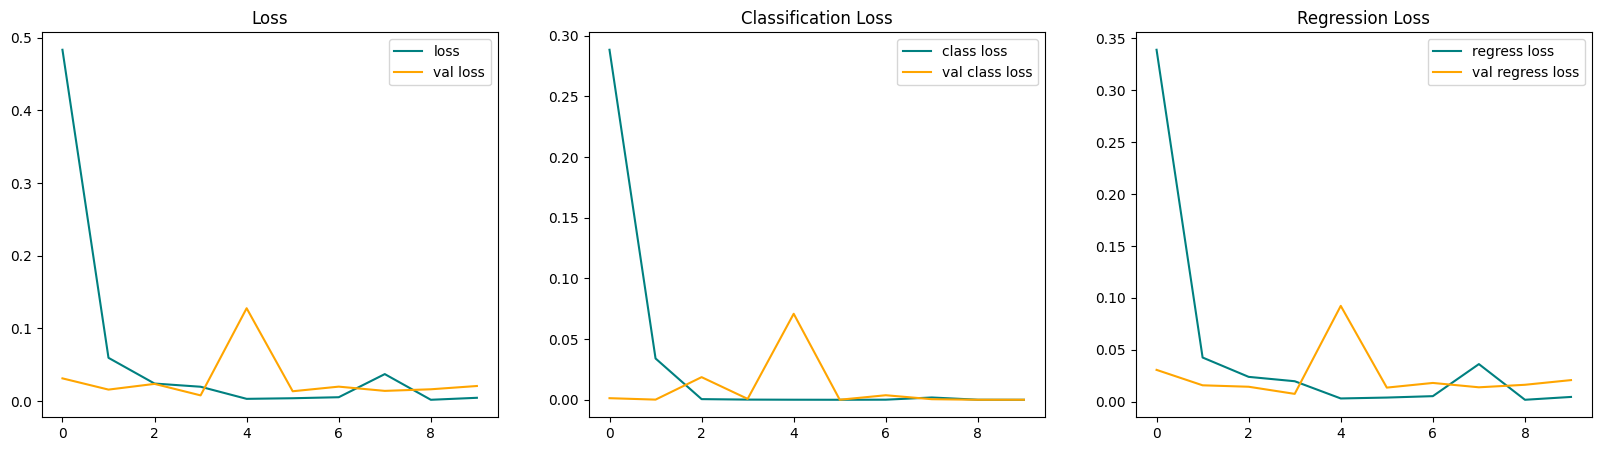

In [128]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make predictions

## 11.1 Make predictions on test set

In [129]:
test_data = test.as_numpy_iterator()

In [147]:

test_sample = test_data.next()# gets next batch 

In [148]:
yhat = facetracker.predict(test_sample[0]) # predicts using test data (Only want X values, not labels)

In [149]:
yhat

[array([[0.9999958 ],
        [0.99998975],
        [0.99999726],
        [0.9999939 ],
        [0.99999475],
        [0.9999919 ],
        [0.9999888 ],
        [0.99999857]], dtype=float32),
 array([[0.28745118, 0.31781036, 0.51909614, 0.6929111 ],
        [0.4925397 , 0.5495269 , 0.7763342 , 0.9530145 ],
        [0.17069738, 0.5419018 , 0.47170603, 0.8923882 ],
        [0.18431629, 0.09087719, 0.4813276 , 0.49555978],
        [0.3642893 , 0.5454641 , 0.5857709 , 0.8765358 ],
        [0.23153313, 0.5893686 , 0.4781595 , 0.9161083 ],
        [0.34020013, 0.55404437, 0.61952055, 0.9478981 ],
        [0.67936766, 0.10164895, 0.9792789 , 0.45448315]], dtype=float32)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


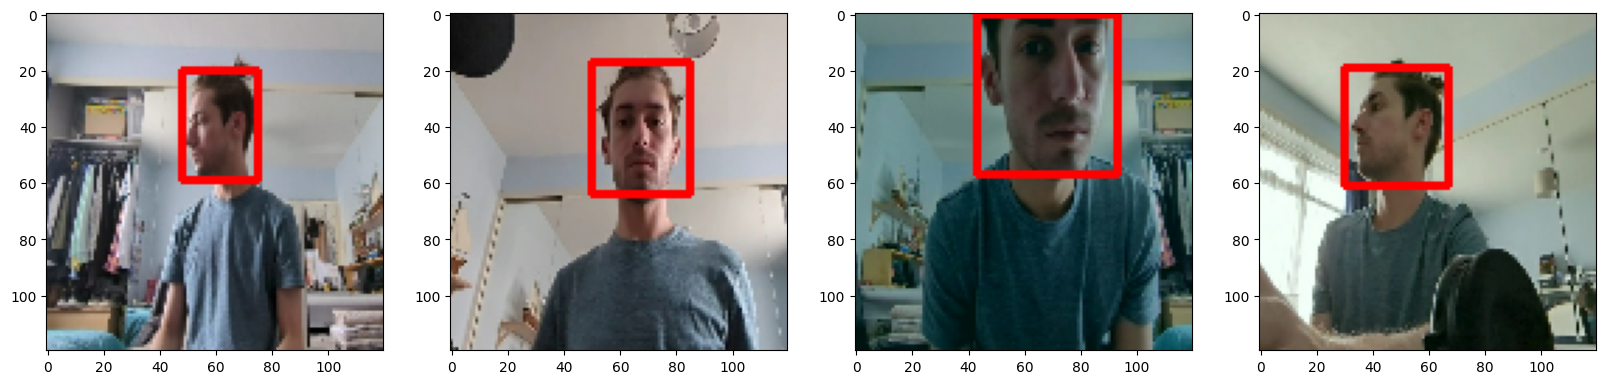

In [144]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9: # is the class rounds to 1, belongs in class 1 and draws rectangle (increase ocnfidence by raising value)
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## 11.2 Save the model

In [150]:
from tensorflow.keras.models import load_model

In [153]:
facetracker.save('model/facetracker.h5')

In [154]:
facetracker = load_model('model/facetracker.h5')

## 11.3 Real-time Detection

In [157]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:] # making video frame to be 450x450 (augmented size)
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # BGR to RGB
    resized = tf.image.resize(rgb, (120,120)) # resize to 120x120
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0)) # normalise pixel values and predict using model
    sample_coords = yhat[1][0]
    
    # Rendering
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    #break out of the loop
    if cv2.waitKey(1) & 0xFF == ord('q'): # press q in the window miltiple times to close camera
        break
cap.release()
cv2.destroyAllWindows()